In [9]:
from IPython.core.interactiveshell import InteractiveShell #display full output instead of just the last one
InteractiveShell.ast_node_interactivity = "all"

### 1. Python - profile a function

Define a decorator for a function

In [1]:
import cProfile

def profileit(filename):
    def inner(func):
        def wrapper(*args, **kwargs):
            prof = cProfile.Profile()
            retval = prof.runcall(func, *args, **kwargs)
            # Note use of name from outer scope
            prof.dump_stats(filename)
            return retval
        return wrapper
    return inner


Wrap a function with the decorator (it will create a new file for each decorated function)

In [2]:
@profileit("log_example")
def example(a: int, b: int):
    for _ in range(int(b)):
        for _ in range(int(b/5)):
            t = a
# You need to run the function
example(0, 1e5)

Evaluate the function using pstats

In [3]:
import pstats
def show_prof(file):
    p = pstats.Stats(file)
    p.sort_stats('tottime').print_stats(10)
for file in ["log_example"]:
    show_prof(file)
    print("\n\n")


Wed May 22 11:14:41 2019    log_example

         2 function calls in 62.755 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   62.755   62.755   62.755   62.755 <ipython-input-2-7ef09a001284>:1(example)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}







### 2. Python - profile line by line

Ref: https://nesi.github.io/perf-training/python-scatter/profiling#profiling-python-code-with-line_profiler

1. Install `line_profiler`:
```bash
$ pip install line_profiler
```

2. Decorate every function you want to profile
```python
@profile
def thing():
    size = 100000
    [1 for _ in range(size)]
```

3. Run the script using `kernprof` in the terminal:
```bash
$ kernprof -l -v script.py
```


### 3. Multiple Learners pipeline

In [1]:
import toolz as fp
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


tt_df_train = pd.DataFrame({
    "text": ["ola eu sou joao", "meu nome é maria", "tres tristes tigres para tres tigres felizes", "1 2 3 4 arroz com batata"],
    "target": [1, 0, 0, 1]
})
tt_df_test = pd.DataFrame({
    "text": ["feliz da vida estou", "na cidade triste dos tempos de aurora"],
    "target": [1, 0]
})
tt_text_col = "text"
tt_target_col = "target"
new_df = tt_df_train
print(new_df[tt_text_col].shape)
print(new_df[tt_target_col].shape)

@fp.curry
def fkl_pipeline(df, clf_obj, clf_name, clf_params, vect_params, text_col, target, prediction_column="prediction"):
    vect = TfidfVectorizer(**vect_params)
    clf = clf_obj(**clf_params)
    vect.fit(df[text_col].values)
    sparse_vect = vect.transform(df[text_col].values)
    clf.fit(sparse_vect, df[target].values)
    def p(new_df):
        predict_text_df = new_df[text_col]
        predict_sparse_vect = vect.transform(predict_text_df)
        col_dict = {prediction_column: clf.predict_proba(predict_sparse_vect)[:, 1]}
        return new_df.assign(**col_dict)
    options = {"model": clf_name,
               "vectorizer": vect,
               "predict_proba": lambda x: clf.predict_proba(vect.transform(x))}
    return p, p(df), options

def build_all_pipelines(vect_params, text_col, target_col):
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression, {}))
    basedModels.append(('KNN'  , KNeighborsClassifier, dict(n_neighbors=2)))
    basedModels.append(('CART' , DecisionTreeClassifier, {}))
    basedModels.append(('NB'   , MultinomialNB, {}))
    basedModels.append(('SVM'  , SVC, dict(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier, {}))
    basedModels.append(('GBM'  , GradientBoostingClassifier, {}))
    basedModels.append(('RF'   , RandomForestClassifier, {}))
    basedModels.append(('ET'   , ExtraTreesClassifier, {}))
    return [{"pipeline": fkl_pipeline(clf_obj=model_obj,
                         clf_name=model_name,
                         clf_params=model_params,
                         vect_params=vect_params,
                         text_col=text_col,
                         target=target_col),
             "model": model_name} for model_name, model_obj, model_params in basedModels]

# Build a specific pipeline
pipeline = fkl_pipeline(clf_obj=ExtraTreesClassifier,
                        clf_name="ET",
                        clf_params={},
                        vect_params={},
                        text_col=tt_text_col,
                        target=tt_target_col)
# Build all pipelines
all_pipe = build_all_pipelines({}, tt_text_col, tt_target_col)
for pdict in all_pipe:
    print(f"Running {pdict['model']}")
    p,new_df, log = pdict["pipeline"](tt_df_train)
    y_pred = p(tt_df_test)["prediction"].values
    y_test = tt_df_test[tt_target_col].values
    print(roc_auc_score(y_test, y_pred))

(4,)
(4,)
Running LR
0.5
Running KNN
0.5
Running CART
0.5
Running NB
0.5
Running SVM
0.5
Running AB
0.5
Running GBM
0.5
Running RF
0.5
Running ET
0.5


/Users/juliano.garcia/miniconda3/envs/gringo-model/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/juliano.garcia/miniconda3/envs/gringo-model/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/juliano.garcia/miniconda3/envs/gringo-model/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == 

### 5. Size of pickled object

In [2]:
def output_pickle_size(object_to_pickle, name="thing"):
    import cloudpickle as cpkl
    import tempfile
    import os
    import subprocess
    print("------------------------------------------------------------------------")
    temp_dir_path = tempfile.mkdtemp()
    temp_output = f"{name}.pkl"
    os.chdir(temp_dir_path)
    cpkl.dump(object_to_pickle, open(temp_output, "wb"))
    print(os.getcwd())
    p = subprocess.Popen(['ls', '-lsah'], stdout=subprocess.PIPE, 
                                stderr=subprocess.PIPE)

    out, err = p.communicate()
    print(out)
    print(err)
    print(f" Manually calculated (MB): {os.stat(temp_output).st_size/1e6}")
    print("------------------------------------------------------------------------")
    
output_pickle_size({"1":2})

------------------------------------------------------------------------
/private/var/folders/xt/0cb4dztx1lv244nd3b8p2q1w0000gn/T/tmpp2a_wfki
b'total 8\n0 drwx------    3 juliano.garcia  staff    96B Jul  4 13:09 .\n0 drwx------@ 377 juliano.garcia  staff    12K Jul  4 13:09 ..\n8 -rw-r--r--    1 juliano.garcia  staff    21B Jul  4 13:09 thing.pkl\n'
b''
 Manually calculated (MB): 2.1e-05
------------------------------------------------------------------------


### 6. Dotdict notation

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

### 7. How to extract Series made of arrays into dataframe columns

In [11]:
col_prefix = "col_extract_"
example_df = pd.DataFrame({"column":[np.random.random((3, )) for _ in range(10)]})
print("---  before --- ")
example_df.head()

values_matrix = np.stack(example_df["column"].values)
output_df = example_df.assign(**{
    col_prefix + str(i): values_matrix[:, i] for i in range(values_matrix.shape[1])
}).drop(columns="column")
print("---  after --- ")
output_df.head()

---  before --- 


,column
0,"[0.45380715508991054, 0.15805359233102678, 0.3..."
1,"[0.6370909734281631, 0.8086877621351344, 0.818..."
2,"[0.947924923168174, 0.7319697369006363, 0.0457..."
3,"[0.6354436688118528, 0.5626937175669025, 0.392..."
4,"[0.939050395044145, 0.042204941416884134, 0.87..."


---  after --- 


,col_extract_0,col_extract_1,col_extract_2
0,0.453807,0.158054,0.375673
1,0.637091,0.808688,0.818033
2,0.947925,0.731970,0.045735
3,0.635444,0.562694,0.392792
4,0.939050,0.042205,0.872930


### 8. Recursively traverse all keys of multilevel dictionary

In [1]:
# The base object can be a dict or a list currently
def myprint(d, curr_indent=0, max_depth=10):
    if curr_indent > max_depth:
        return
    if isinstance(d, dict):
        for k, v in d.items():
            print("\t"*curr_indent + str(k))
            myprint(v, curr_indent=curr_indent + 1, max_depth=max_depth)
    elif isinstance(d, list):
        for l in d:
            print("")
            myprint(l, curr_indent=curr_indent + 1, max_depth=max_depth)
    elif isinstance(d, set):
        for l in sorted(d):
            print("\t"*curr_indent + str(l))
            myprint(l, curr_indent=curr_indent + 1, max_depth=max_depth)


In [2]:
multilevel_dict = dict(a=dict(a1=dict(a11=1, a12=2)), b=dict(b1=dict(b11=1, b12=2), b2=dict(b21=1, b22=2)))
myprint(multilevel_dict)

a
	a1
		a11
		a12
b
	b1
		b11
		b12
	b2
		b21
		b22


### 9. Colorize strings in unix shell

In [3]:
class colorize():
    """colorize strings in a bash shell"""
    def red(text):
        return f"\033[1;91m{text}\033[39m"

    def green(text):
        return f"\033[1;92m{text}\033[39m"

    def yellow(text):
        return f"\033[1;93m{text}\033[39m"

    def blue(text):
        return f"\033[1;94m{text}\033[39m"

    def magenta(text):
        return f"\033[1;95m{text}\033[39m"

    def cyan(text):
        return f"\033[1;96m{text}\033[39m"

    def white(text):
        return f"\033[1;97m{text}\033[39m"

In [6]:
print(colorize.red("oi"))

oi


### 9. Goodness of fit - main distribution

Using chi-square test. Be mindful of chi-square assumptions (independent data, etc)

In [17]:
def goodness_of_fit_chisquare(vals, dist_names=None, num_of_percentile_bins=21):
    import scipy
    if dist_names is None:
        dist_names = ["weibull_min","norm","weibull_max","beta",
                      "invgauss","uniform","gamma","expon",
                      "lognorm","pearson3", "triang"]

    chi_square_statistics = []
    percentile_bins = np.linspace(0, 100, num_of_percentile_bins)
    percentile_cutoffs = np.percentile(vals, percentile_bins)
    observed_frequency, bins = (np.histogram(vals, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)
    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(vals)
        print("{}\n{}\n".format(dist, param))
        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * len(vals)
        cum_expected_frequency = np.cumsum(expected_frequency)
        # let's avoid frequency with zeros...
        if any((x < 1e-6 for x in cum_observed_frequency)):
            print("WARNING: SOME OF YOUR DATA HAS FREQ of 0! try to fix this!")
        ss = np.nansum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Goodness of fit:')
    print ('............................................')
    print (results)
    return results


Application

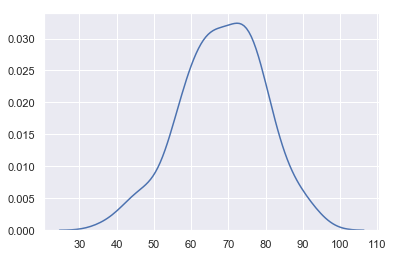

In [22]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(seed=42)
sns.set()
my_variable_vals = stats.norm.rvs(loc=50, scale=10, size=100)+np.random.randint(10, 30, (100))
sns.distplot(my_variable_vals, hist=None)

In [23]:
goodness_of_fit_chisquare(my_variable_vals)

(0.26393349939568844, 37.802548959102545, 1.487676730898348)

(68.33153482605907, 11.057667422227732)

(0.2672180121466247, 93.23029856408027, 1.3638983943482386)

(13.497261193884889, 7.433631705996732, -1.4714782787799994, 108.24637229202767)

(0.030640133945062764, 0.8851207006607069, 2189.175223423026)

(37.80254895910255, 55.427749604977706)

(346.76114556646894, -139.75987282245183, 0.6000087666849256)

(37.80254895910255, 30.528985866956518)

(3.3994640953384767, 37.80253690506444, 1.2597613917289157)

(-0.29906076977183027, 68.33155840561633, 11.068243566663472)

(0.6439829510443277, 36.26466070815907, 58.31309205658908)


Distributions listed by Goodness of fit:
............................................
   Distribution   chi_square
3          beta     1.783657
1          norm     2.447518
6         gamma     3.174421
10       triang     7.578480
4      invgauss    11.586138
5       uniform   149.817303
7         expon   417.628602
2   weibull_max   758.787636
8       lognor

,Distribution,chi_square
3,beta,1.783657
1,norm,2.447518
6,gamma,3.174421
10,triang,7.578480
4,invgauss,11.586138
5,uniform,149.817303
7,expon,417.628602
2,weibull_max,758.787636
8,lognorm,2220.202609
0,weibull_min,2797.759282


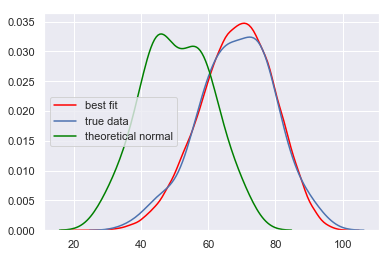

In [28]:
sns.distplot(stats.beta(13.497261193884889, 7.433631705996732, -1.4714782787799994, 108.24637229202767).rvs(size=80000), hist=None, color="red", label="best fit")
sns.distplot(my_variable_vals, hist=None, label="true data") 
sns.distplot(stats.norm.rvs(loc=50, scale=10, size=100), color="green", label="theoretical normal", hist=None)

### 10. Difference Between Dictionaries

In [ ]:
def findDiff(d1, d2, path=""):
    for k in d1:
        if (k not in d2):
            print (path, ":")
            print (k + " as key not in d2", "\n")
        else:
            if type(d1[k]) is dict:
                if path == "":
                    path = k
                else:
                    path = path + "->" + k
                findDiff(d1[k], d2[k], path)
            else:
                if d1[k] != d2[k]:
                    print (path, ":")
                    print (" - ", k," : ", d1[k])
                    print (" + ", k," : ", d2[k])


### 11. Order s3 by date

In [2]:
import boto3
import pandas as pd
s3 = boto3.client('s3')
objs = s3.list_objects_v2(Bucket='bucket', Prefix='folder1/folder2/')
contents_df = pd.DataFrame(contents)
contents_df['obj'] = contents_df['Key'].str.split('/').str[2]
(contents_df
 .groupby('obj')['LastModified']
 .max()
 .sort_values()
 .index
 .tolist())
contents = objs['Contents']

### 12. Standardized Mean Difference between two groups

In [ ]:
def smd(group_a, group_b, feature):
    diff_mean = np.mean(group_a[feature].values) - np.mean(group_b[feature].values)
    stds = np.sqrt((np.var(group_a[feature].values, ddof=1) + np.var(group_b[feature].values, ddof=1))/2)
    return diff_mean/stds